# Сверточные слои в Tensorflow

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
from tensorflow.keras.layers import Conv2D

In [3]:
# Conv2D?

In [4]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import scipy as sp
import tensorflow as tf
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.3.1-arm64-i386-64bit
Tensor Flow Version: 2.12.0
Keras Version: 2.12.0

Python 3.8.12 | packaged by conda-forge | (default, Sep 29 2021, 19:21:23) 
[Clang 11.1.0 ]
Pandas 1.5.3
Scikit-Learn 1.2.2
SciPy 1.9.1
GPU is available


 <img src="https://drive.google.com/uc?export=view&id=1s5twLjOyr46Z1X-TbsodlmtVxBoDtZac" width=600>


```
Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', ...)
```


*   filters -- количество выходных каналов. M -- на иллюстрации выше
*   kernel_size -- размер фильтра (ядра). (k,k) -- на иллюстрации.
*   padding -- значение "valid" по умолчанию, означает, что свертка "откусит" часть входного тензора. Например, при размере фильтра 3 -- размер уменьшится на пиксель с каждой стороны, при фильтре 5 -- на два и т.д. Второе значение -- "same", автоматически подберет паддинг из нулей для того, чтобы размер не изменился
*   activation -- знакомая нам активация (например, "relu"). Применяется сразу после свертки и добавления вектора смещения поэлементно
*   use_bias -- использовать ли смещение после свертки. Добавляет число к каждому из выходных каналов
*   kernel_initializer, bias_initializer -- инициализаторы ядра и смещения, аналогично Dense слою

Обратите внимаение, мы не указали количество входных каналов. Как и в случае полносвязного слоя, Keras вычислит это автоматически.


Для знакомства со сверточным слоем -- реализуем операцию свертки, которую мы считали на лекции.

 <img src="https://drive.google.com/uc?export=view&id=19HWr8k2ZJBglnIpTuEcaWW7DfC_76Jet" width=400>



In [5]:
signal = np.array([
    [3, 3, 2, 1, 0],
    [0, 0, 1, 3, 1],
    [3, 1, 2, 2, 3],
    [2, 0, 0, 2, 2],
    [2, 0, 0, 0, 1]])

# для начала создадим слой. количество выходных каналов -1, размер (3, 3)
conv_layer = Conv2D(kernel_size=(3, 3), filters=1, use_bias=False)

# применим слой (пусть пока со случайным фильтром) ко входу и получим ошибку
_ = conv_layer(signal)

ValueError: Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (5, 5)

Получаем ошибку о несовпадении размерностей. Слой ожидает четырехмерный тензор а получает двумерный. Одна из потерянных размерностей это -
число каналов. Хоть мы и применяем фильтр к двумерному массиву с одним каналом - мы должны описать эту размерность. Вторая - batch dimension, которая отвечает за количество объектов. В нашем примере это 1.

In [6]:
# Используем метод reshape
signal = signal.reshape((1, 5, 5, 1)).astype(np.float32)
print(signal.shape)

(1, 5, 5, 1)


In [7]:
output = conv_layer(signal) # теперь код работает без ошибки
output.numpy().shape

(1, 3, 3, 1)

In [8]:
# размер фильтра (k, k, количество_входных_каналов, количество_каналов_на_выходе)
conv_layer.get_weights()[0].shape

(3, 3, 1, 1)

А теперь инициализируем наш слой с помощью ядра, которое опишем ниже. Мы воспользуемся методом set_weights(). На практике мы почти 
никогда не инициализируем парамертры самостоятельно, но в данном случае воспользуемся этим в образовательных целях.

In [9]:
kernel = np.array([[0, 1, 2],
                   [2, 2, 0],
                   [0, 1, 2]])
kernel = kernel.reshape((3, 3, 1, 1)).astype(np.float32)

In [10]:
conv_layer.set_weights([kernel])
conv_layer(signal)[0, :, :, 0].numpy()

array([[12., 12., 17.],
       [10., 17., 19.],
       [ 9.,  6., 14.]], dtype=float32)

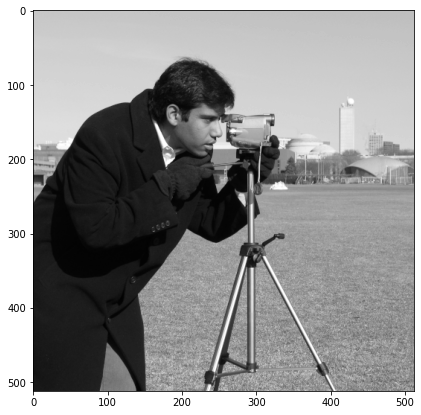

In [11]:
from skimage import data
import matplotlib.pyplot as plt

image = data.camera()
plt.figure(figsize=(7, 7))
plt.imshow(image, cmap='gray')

In [12]:
print(image.shape)
image = image[None, ..., None] # так тоже можно добавлять дополнительные размерности
print(image.shape)
image = image.astype(np.float32) / 255. # обязательно приводим к float

(512, 512)
(1, 512, 512, 1)


In [13]:
conv_layer = Conv2D(kernel_size=(7, 7), filters=1, use_bias=False) # используем фильтр размера (7, 7)
                                                                   # и т.к. мы хотим на выходе получить одноканальное 
                                                                   # изображение укажем количество каналов на выходе = 1
_ = conv_layer(image) # чтобы получить доступ ко всем весам слоя нужно этим воспользоваться.

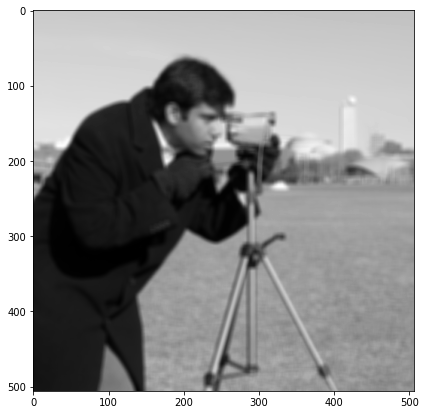

In [14]:
kernel = np.ones((7, 7, 1, 1)) * 1./49 # усредняем значение всех пикселов, которые попали в окошко (7, 7)
conv_layer.set_weights([kernel])

blur_image = conv_layer(image).numpy()
plt.figure(figsize=(7, 7))
plt.imshow(blur_image[0, :, :, 0], cmap='gray')

In [15]:
# обратите внимание на размеры:
image.shape, blur_image.shape
# свертка размера 7 без паддинга съест по 3 пиксела с каждой стороны -- 512 - 3*2 = 506

((1, 512, 512, 1), (1, 506, 506, 1))

(1, 400, 600, 3)

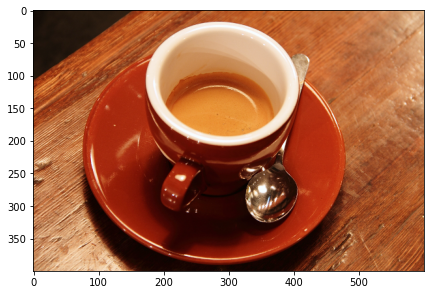

In [16]:
image = data.coffee()
plt.figure(figsize=(7, 7))
plt.imshow(image)
image = image[None, :, :].astype(np.float32) / 255.
image.shape

In [17]:
conv_layer = Conv2D(kernel_size=(5, 5), filters=3, use_bias=False)
_ = conv_layer(image)
conv_layer.get_weights()[0].shape

(5, 5, 3, 3)

Попробуем теперь определить фильтр для цветного изображения.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input shape (1, 400, 600, 3). Output shape (1, 396, 596, 3)


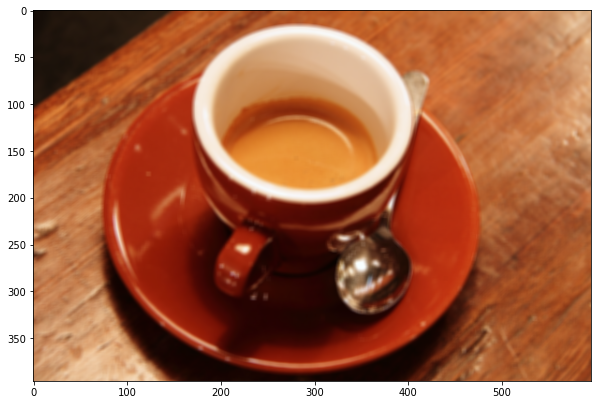

In [18]:
kernel = np.zeros((5, 5, 3, 3))

kernel[:, :, 0, 0] = 1/25. # размытие нулевого канала 0, 0 - означает, что нулевой канал выхода зависит от нулевого канала входа
                           # [:, :, 1, 0] и [:, :, 2, 0] - остались равными нулю.
kernel[:, :, 1, 1] = 1/25.
kernel[:, :, 2, 2] = 1/25.
conv_layer.set_weights([kernel])


plt.figure(figsize=(10, 10))
plt.imshow(conv_layer(image).numpy()[0])
print(f'Input shape {image.shape}. Output shape {conv_layer(image).numpy().shape}')

Input shape (1, 400, 600, 3). Output shape (1, 396, 596, 3)


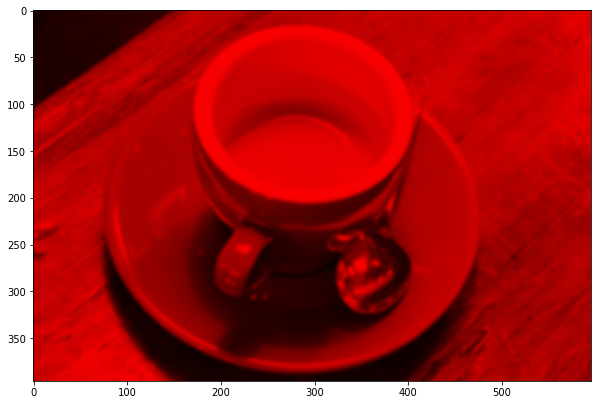

In [19]:
kernel = np.zeros((5, 5, 3, 3))

kernel[:, :, 0, 0] = 1/25. # размытие нулевого канала 0, 0 - означает, что нулевой канал выхода зависит от нулевого канала входа
                           # [:, :, 1, 0] и [:, :, 2, 0] - остались равными нулю.

conv_layer.set_weights([kernel])


plt.figure(figsize=(10, 10))
plt.imshow(conv_layer(image).numpy()[0])
print(f'Input shape {image.shape}. Output shape {conv_layer(image).numpy().shape}')

Но свертки можно применять не только к изображениям. Ниже несколько примеров.

In [20]:
conv_layer = Conv2D(kernel_size=(5, 5), filters=30)
sample_input = np.random.rand(1, 200, 300, 20)
conv_layer(sample_input).numpy().shape

(1, 196, 296, 30)

In [21]:
conv_layer = Conv2D(kernel_size=(5, 5), filters=30, padding='same')
sample_input = np.random.rand(1, 200, 300, 20)
conv_layer(sample_input).numpy().shape

(1, 200, 300, 30)

In [22]:
# Можно добавьть активацию Обратите внимание - на выходе только неотрицательные значение, это работа ReLU
conv_layer = Conv2D(kernel_size=(3, 3), filters=1, padding='same', activation='relu')
sample_input = np.random.rand(1, 5, 5, 1)
conv_layer(sample_input).numpy()[0, :, :, 0]

array([[0.        , 0.        , 0.05581601, 0.        , 0.        ],
       [0.07906757, 0.24303888, 0.        , 0.270649  , 0.20064145],
       [0.        , 0.32163215, 0.3737951 , 0.        , 0.03252257],
       [0.10136956, 0.15408042, 0.37739205, 0.64276797, 0.        ],
       [0.18673065, 0.4571816 , 0.43147302, 0.34682044, 0.4518894 ]],
      dtype=float32)